In [1]:
import numpy as np
import os, sys
from skimage import io
import matplotlib
from pprint import pprint
from matplotlib import pyplot as plt
from tqdm import tqdm
import neuroglancer
import cv2

#from PIL import Image
#Image.MAX_IMAGE_PIXELS = None

In [15]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(PATH)
from utilities.sqlcontroller import SqlController
from utilities.file_location import DATA_PATH, ROOT_DIR


In [16]:
sqlController = SqlController('Atlas')
atlas_centers = sqlController.get_centers_dict('Atlas',input_type_id=1, person_id=16)

No histology for Atlas
No scan run for Atlas


In [17]:
atlas_centers

{'10N_L': [203.341, 47.9286, -29.0],
 '10N_R': [203.341, 47.9286, 29.0],
 '12N': [197.227, 67.0988, -2.0],
 '3N_L': [-135.445, -108.494, -14.0],
 '3N_R': [-135.445, -108.494, 14.0],
 '4N_L': [-100.559, -103.896, -25.0],
 '4N_R': [-100.559, -103.896, 25.0],
 '5N_L': [-43.2008, 2.07948, -136.0],
 '5N_R': [-43.2008, 2.07948, 136.0],
 '6N_L': [17.1597, 12.4922, -35.0],
 '6N_R': [17.1597, 12.4922, 35.0],
 'AP': [202.306, 25.6525, 2.0],
 'Amb_L': [112.44, 103.826, -123.0],
 'Amb_R': [112.44, 103.826, 123.0],
 'DC_L': [83.2885, -43.5046, -216.0],
 'DC_R': [83.2885, -43.5046, 216.0],
 'IC': [-3.2471, -248.307, 0.0],
 'LC_L': [-3.80266, -57.1921, -84.0],
 'LC_R': [-3.80266, -57.1921, 84.0],
 'LRt_L': [188.194, 146.863, -112.0],
 'LRt_R': [188.194, 146.863, 112.0],
 'PBG_L': [-103.962, -127.015, -186.0],
 'PBG_R': [-103.962, -127.015, 186.0],
 'Pn_L': [-171.668, 93.0847, -55.0],
 'Pn_R': [-171.668, 93.0847, 55.0],
 'RtTg': [-121.546, 62.2477, -4.0],
 'SC': [-128.018, -241.129, 3.0],
 'SNC_L': [-

In [ ]:
BASEINPUT = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/CHATM2/preps'
INPUT = os.path.join(BASEINPUT, '3channels')
files = sorted(os.listdir(INPUT))
midpoint = len(files) // 2
midfilepath = os.path.join(INPUT, files[midpoint])
limit = 1
#files = files[midpoint-limit:midpoint+limit]
#files = files[midpoint]
midfile = cv2.imread(midfilepath)
print(midpoint, midfile.shape, midfile.dtype)
#height, width = midfile.shape
#data_type = np.uint8
#volume_size = (width, height, len(files))
#volume = np.zeros((volume_size), dtype=data_type)

In [ ]:
# use skimage
for f in tqdm(files):
    infile = os.path.join(INPUT, f)
    img = cv2.imread(infile)
    ch1_img = img[:,:,0]
    ch2_img = img[:,:,1]
    ch3_img = img[:,:,2]
    ch1_outpath = os.path.join(BASEINPUT, 'CH1/thumbnail', f)
    ch2_outpath = os.path.join(BASEINPUT, 'CH2/thumbnail', f)
    ch3_outpath = os.path.join(BASEINPUT, 'CH3/thumbnail', f)
    cv2.imwrite(ch1_outpath, ch1_img.astype(np.uint8))
    cv2.imwrite(ch2_outpath, ch2_img.astype(np.uint8))
    cv2.imwrite(ch3_outpath, ch3_img.astype(np.uint8))


In [2]:
filepath = "/net/birdstore/Active_Atlas_Data/data_root/atlas_data/shapes/DK52/infrahypoglossal.npy"
#volume = io.imread(midfilepath)
volume = np.load(filepath)
print(volume.shape, volume.dtype)

(20, 5, 9) uint8


In [ ]:
labels = [[v-8,v-1] for v in range(9,256,8)]
print(labels)

In [ ]:
arr = np.copy(volume)
for label in labels:
    mask = (arr >= label[0]) & (arr <= label[1])
    arr[mask] = label[1]
arr[arr > 248] = 255

In [3]:
#volume = volume.reshape(volume.shape[0], volume.shape[1], volume.shape[2])
arr = volume.copy()
print('volume shape', arr.shape, arr.dtype, np.unique(arr, return_counts=False))

volume shape (20, 5, 9) uint8 [0 9]


Text(0.5, 1.0, ' uint8')

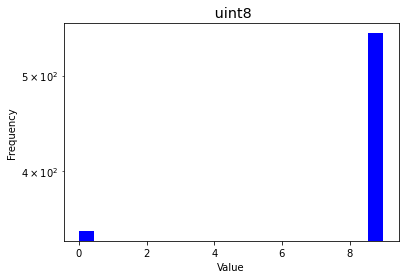

In [4]:
#volume[volume > 0] = 255
#volume[volume < 1] = 0
flat = arr.flatten()
fig = plt.figure()
plt.rcParams['figure.figsize'] = [10, 6]
plt.hist(flat, bins=20, color='b')
plt.style.use('ggplot')
plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f' {arr.dtype}')

(20, 5, 9)


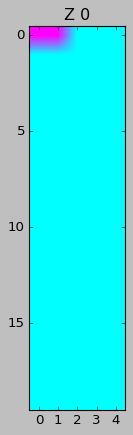

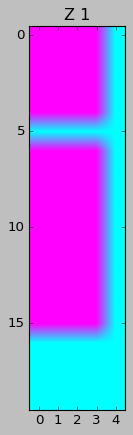

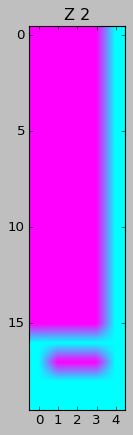

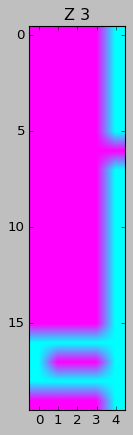

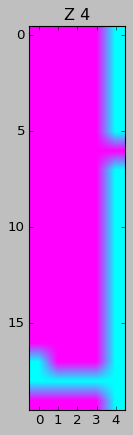

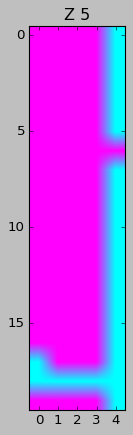

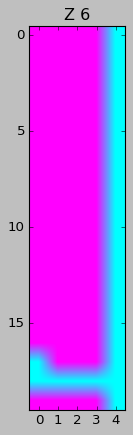

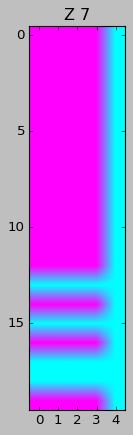

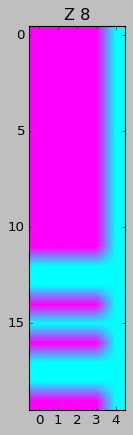

IndexError: index 9 is out of bounds for axis 2 with size 9

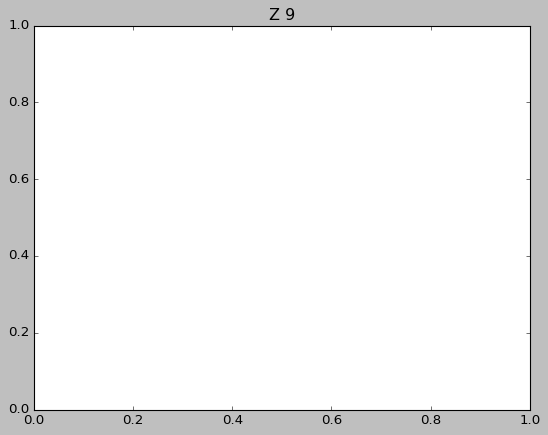

In [12]:
arr = volume.copy()
#arr = np.rot90(volume, axes=(2, 1))
#arr = np.rot90(arr, 3)
arr = np.flip(arr, axis=1)    
print(arr.shape)
start = 0
end = arr.shape[0]
nrows = end - start
ncols = 1
plt.style.use('classic')
for i in range(start, end-2):
    plt.title('Z {}'.format(i))
    plt.imshow(arr[:,:,i], cmap="cool")
    plt.show()

In [ ]:
dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='nm',
    scales=[1000,1000,1000])

viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layers['Altas'] = neuroglancer.ImageLayer(
        source=neuroglancer.LocalVolume(
            data=volume,
            dimensions=dimensions,
            voxel_offset=(0, 0, 0),
        ),
        shader="""
#uicontrol float min slider(min=0, max=1, default=0)
#uicontrol float max slider(min=0, max=1, default=1)
#uicontrol float invert slider(min=0, max=1, default=0, step=1)
#uicontrol float brightness slider(min=-1, max=1)
#uicontrol float contrast slider(min=-3, max=3, step=0.01)
void main() {
  float pix_val = toNormalized(getDataValue());
  if(pix_val < min){
  	pix_val = 0.0;
  }
  if(pix_val > max){
    pix_val = 1.0;
  }

  if(invert==1.0){
  	  emitGrayscale((1.0 -(pix_val - brightness)) *
       exp(contrast));
  }
  else{
    emitGrayscale((pix_val + brightness) *
                  exp(contrast));
  }

}

""")
print(viewer)

In [ ]:
files